## Text Classification on Spam Email

The project focuses on the "Spam or Not Spam Dataset," which is a collection of emails labeled as either spam or not spam:
Dataset: https://www.kaggle.com/ozlerhakan/spam-or-not-spam-dataset


The aim of this project is to train and evaluatemachine learning models in the field of email spam classification. By training the model that can accurately classify incoming emails as spam, it is able to filter out unwanted and potentially harmful messages.


## **PART 1** Text Conversion
 Convert the Text column to counter columns (Text data to numerical data)

**Read dataset**

In [15]:
import pandas as pd

dataset = pd.read_csv('spam_or_not_spam.csv') # import dataset using pandas

dataset.label.value_counts() # 83.3% Good, 16.6% Bad 

dataset.info() # check the null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [ ]:
#dataset.head()

#### Explore the loaded data
1.  label 0: Good
2.  label 1: Bad (spam)


**Remove the missing data**

In [19]:
dataset[dataset.email.isnull()] 
dataset.email.fillna('', inplace=True)

**Split the data into training and testing set**

In [20]:
X, y = dataset.email, dataset.label

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,  random_state=1)

**vec.fit()**: learn the vocabulary term from the training data

In [26]:
from sklearn.feature_extraction.text import CountVectorizer 
vec = CountVectorizer(stop_words='english', lowercase=True)

vec.fit(X_train)

dict

**vec.transform()** :  Count the occurances of each term in each ROW in training dataset

In [30]:
X_train_dt = vec.transform(X_train) # CONVERT the text to the term columns and count the occurances
X_train_dt 

<2250x29247 sparse matrix of type '<class 'numpy.int64'>'
	with 184665 stored elements in Compressed Sparse Row format>

## **PART 2 Classification**
Do Classification with the converted numerical data

**Classifier**

In [32]:
%%time
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

model = MultinomialNB() # for discrete frequency features

model.fit(X_train_dt.toarray(), y_train) # train the model

Wall time: 1.92 s


MultinomialNB()

In [33]:
%%time

X_test_dt = vec.transform(X_test) 
pred = model.predict(X_test_dt.toarray()) 
prob = model.predict_proba(X_test_dt.toarray()) # predict the probability that it could be a spam

Wall time: 455 ms


### Model evaluation

**Scoring**
* https://scikit-learn.org/stable/modules/model_evaluation.html

In [34]:
# accuracy_score on test set
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, pred)  # TEST SET accuracy of MultinomialNB
print(f'Accuracy score: {accuracy}')

# precision_score, recall_score, f1_score on test set
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
print(f'precision score: {precision}')
print(f'recall score: {recall}')
print(f'f1 score: {f1}')

Accuracy score: 0.9906666666666667
precision score: 0.9919354838709677
recall score: 0.9534883720930233
f1 score: 0.9723320158102766


In [35]:
from sklearn import metrics
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       621
           1       0.99      0.95      0.97       129

    accuracy                           0.99       750
   macro avg       0.99      0.98      0.98       750
weighted avg       0.99      0.99      0.99       750



**Compare the accuracy with baseline accuracy**

**Confusion Matrix**

In [45]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, pred)
print(confusion)

# True negative, false positive, false negative, true positive for binary classification
tn, fp, fn, tp = confusion.ravel()
print(f'TN: {tn}')
print(f'TP: {tp}')
print(f'FP: {fp}')
print(f'FN: {fn}')

[[620   1]
 [  6 123]]
TN: 620
TP: 123
FP: 1
FN: 6


**ROC curve**

(0.0, 1.0)

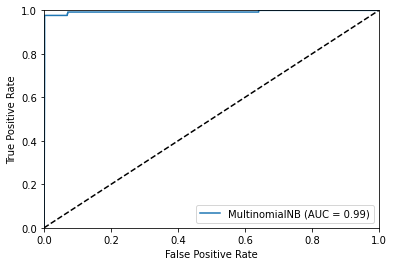

In [46]:
# PLOT ROC curve on testing set
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model, X_test_dt.toarray(), y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0,1])
plt.ylim([0,1])

(0.0, 1.0)

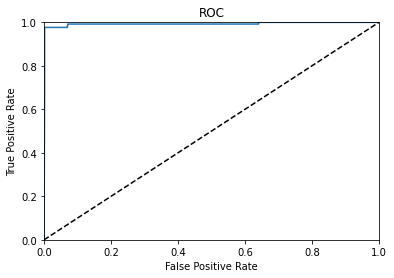

In [47]:
# ROC curve on Testing set
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prob[:,1]) # pass label and prob
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0,1])
plt.ylim([0,1])

**AUC (Area under the ROC Curve)**

In [48]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, prob[:,1])

0.9929471095632201

**Cross-validated ROC curve**
* **cross_val_predict()**

AUC: 0.99


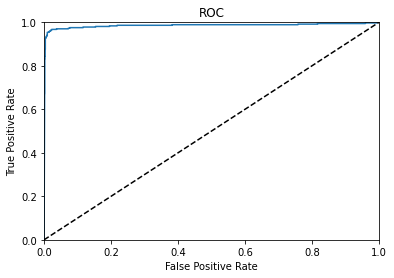

In [52]:
from sklearn.model_selection import cross_val_predict
y_prob_cv = cross_val_predict(model, X_train_dt.toarray(), y_train, cv=3, method='predict_proba')
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_prob_cv[:, 1])

plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0,1])
plt.ylim([0,1])

from sklearn.metrics import roc_auc_score
auc_cv = roc_auc_score(y_train, y_prob_cv[:, 1])
print(f'AUC: {auc_cv:.2f}')

**Save the model**

In [53]:
import joblib
count_vectorizer_filename = 'vec.sav'
classifier_filename = 'spam_classifer.sav'
joblib.dump(vec, count_vectorizer_filename)
joblib.dump(model, classifier_filename)

['spam_classifer.sav']

**Load the model**

In [54]:
import joblib
count_vectorizer_filename = 'vec.sav'
classifier_filename = 'spam_classifer.sav'
vec = joblib.load(count_vectorizer_filename)
model = joblib.load(classifier_filename)

**Apply it on unseen data:**
* Convert & Predict using loaded vectorizer & model

In [56]:
# step 1 transform using the vectorizer

unknown_dt = vec.transform(['Hi, I will send you the documents later. Regards, Paul', 
                            'Call 1234-5678 on this awesome opportunity'])

# step 2 predict using the model

model.predict(unknown_dt.toarray())

array([0, 1], dtype=int64)